In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model


from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

In [128]:
!pip install keras_tuner
!pip install scikeras

## Creating Training Data

In [129]:
# uncomment if using colab
! git clone https://github.com/Daniel-Tran3/CSE_151A_Project.git

fatal: destination path 'CSE_151A_Project' already exists and is not an empty directory.


In [130]:
from keras.models import load_model
# The model contained in this filepath was obtained by running Model_1's notebook.
ANNmodel = load_model('CSE_151A_Project/ANN_model.keras')

ANNmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 24)                39768     
                                                                 
 dense_4 (Dense)             (None, 24)                600       
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 40393 (157.79 KB)
Trainable params: 40393 (157.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [131]:
data = pd.read_csv('CSE_151A_Project/final_cleaned.csv', on_bad_lines='skip')
data.head()

,bathrooms,bedrooms,price,square_feet,time,state_AK,state_AL,state_AR,state_AZ,state_CA,...,Gym,TV,Hot Tub,Tennis,Wood Floors,View,Alarm,Doorman,Luxury,Golf
0,1.0,0.0,0.011281,0.000000,2019-12-26 11:23:35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,0.004302,0.000125,2019-12-22 12:17:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,0.022753,0.000150,2019-12-26 11:23:30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,0.013862,0.000376,2019-12-18 11:15:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,0.013002,0.000602,2019-12-26 11:23:21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
  display(data)

bathrooms  bedrooms     price  square_feet                 time  \
0           1.0       0.0  0.011281     0.000000  2019-12-26 11:23:35   
1           1.0       1.0  0.004302     0.000125  2019-12-22 12:17:43   
...         ...       ...       ...          ...                  ...   
9996        1.0       1.0  0.087763     1.000000  2019-12-26 12:09:46   
9997        1.0       1.0  0.015468     0.019524  2019-12-26 12:09:01   

      state_AK  state_AL  state_AR  state_AZ  state_CA  state_CO  state_CT  \
0            0         0         0         0         0         0         0   
1            0         0         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
9996         0         0         0         0         0         0         0   
9997         0         0         0         0         0         0         0   

      state_DC  state_DE  state_FL  state_GA  state_HI  state_IA  state_ID  \
0            1         0         0         0         0         0         0   
1            0         0         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
9996         0         0         0         0         0         0         0   
9997         0         0         0         1         0         0         0   

      state_IL  state_IN  state_KS  state_KY  state_LA  state_MA  state_MD  \
0            0         0         0         0         0         0         0   
1            0         1         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
9996         0         0         0         0         0         0         0   
9997         0         0         0         0         0         0         0   

      state_ME  state_MI  state_MN  state_MO  state_MS  state_MT  state_NC  \
0            0         0         0         0         0         0         0   
1            0         0         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
9996         0         0         0         0         0         0         0   
9997         0         0         0         0         0         0         0   

      state_ND  state_NE  state_NH  state_NJ  state_NM  state_NV  state_NY  \
0            0         0         0         0         0         0         0   
1            0         0         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
9996         0         0         0         0         0         0         1   
9997         0         0         0         0         0         0         0   

      state_OH  state_OK  state_OR  state_PA  state_RI  state_SC  state_SD  \
0            0         0         0         0         0         0         0   
1            0         0         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
9996         0         0         0         0         0         0         0   
9997         0         0         0         0         0         0         0   

      state_TN  state_TX  state_UT  state_VA  state_VT  state_WA  state_WI  \
0            0         0         0         0         0         0         0   
1            0         0         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
9996         0         0         0         0         0         0         0   
9997         0         0         0         0         0         0         0   

      state_WV  state_WY  state_nan  cityname_Aberdeen  cityname_Abilene  \
0            0         0          0                  0                 0   
1            0         0          0                  0                 0   
...        ...       ...        ...                ...  

In [133]:
X = data.drop(['price', 'time'], axis=1)
fairness_data = data.copy()
fairness_data['predicted_price'] = ANNmodel.predict(X)
fairness_data.head()

313/313 [==============================] - 2s 5ms/step


,bathrooms,bedrooms,price,square_feet,time,state_AK,state_AL,state_AR,state_AZ,state_CA,...,TV,Hot Tub,Tennis,Wood Floors,View,Alarm,Doorman,Luxury,Golf,predicted_price
0,1.0,0.0,0.011281,0.000000,2019-12-26 11:23:35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1773.028076
1,1.0,1.0,0.004302,0.000125,2019-12-22 12:17:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,564.618286
2,1.0,0.0,0.022753,0.000150,2019-12-26 11:23:30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1289.576904
3,1.0,0.0,0.013862,0.000376,2019-12-18 11:15:43,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1565.849365
4,1.0,0.0,0.013002,0.000602,2019-12-26 11:23:21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1291.815063


In [134]:
# if the actual price is less than 1.3 times the predicted price, the value in the fairness column is 'fair', otherwise it is 'unfair'
unprocessed_data = pd.read_csv('CSE_151A_Project/apartments_for_rent_classified_10K_utf.csv')
fairness_data['unscaled_price'] = unprocessed_data['price']
fairness_data['fairness'] = np.where((fairness_data['unscaled_price'] < (fairness_data['predicted_price']*1.3)), 'fair', 'unfair')
fairness_data['fairness'].value_counts()

fair      7514
unfair    2484
Name: fairness, dtype: int64

In [135]:
# drop time since machine cant train on DateTime type
y = np.where(fairness_data.fairness == 'fair', 1, 0)
X = fairness_data.drop(columns=['time', 'fairness', 'predicted_price', 'unscaled_price'])

# split the data into training, testing, and validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state = 50)

## Logistic Regression With Keras Hyperparameter Tuning

In [136]:
from keras.optimizers import Adam, Adadelta

import keras
from keras import layers

# Define function to use given hyperparameter options to build model
# Options: number of units, optimizer, activation function, learning rate
def call_existing_code(units, optimizer_candidate, activation, lr):
  model = keras.Sequential()
  model.add(layers.Dense(units=16, activation=activation, input_dim=X_train.shape[1]))
  model.add(layers.Dense(units=units, activation=activation))
  model.add(layers.Dense(units=units, activation=activation))
  model.add(layers.Dense(units=units, activation=activation))
  model.add(layers.Dense(units=units, activation=activation))
  model.add(layers.Dense(1, activation="sigmoid"))
  if (optimizer_candidate=="SGD"):
    optimizer=SGD(lr)
  elif (optimizer_candidate=="Adam"):
    optimizer=Adam(lr)
  elif (optimizer_candidate=="Adadelta"):
    optimizer=Adadelta(lr)
  else:
    optimizer=optimizer_candidate
  model.compile(
      optimizer=optimizer,
      loss="binary_crossentropy",
      metrics=["accuracy"],
  )
  return model

# Build model, using hyperparameters to choose options and use function above to build model
def build_model(hp):
  units = hp.Int("units", min_value=6, max_value=18, step=6)
  activation = hp.Choice("activation", ["relu", "tanh", "sigmoid"])
  lr = hp.Float("lr", min_value=0.1, max_value=0.9, step=0.4, sampling="linear")
  optimizer= hp.Choice("optimizer", ["SGD", "Adam", "Adadelta"])
  # call existing model-building code with the hyperparameter values.
  model = call_existing_code(
      units=units, optimizer_candidate=optimizer, activation=activation, lr=lr
  )
  return model

In [137]:
import keras_tuner

# Build model using previous two functions
build_model(keras_tuner.HyperParameters())

# Create tuner to scan over search space with GridSearch
tuner = keras_tuner.GridSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=81,
    executions_per_trial=1,
    overwrite=True,
    directory="proj_dir",
    project_name="TuningProject"
)

# Summarize search space
tuner.search_space_summary()


# Runs search and prints best accuracy found
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Trial 81 Complete [00h 00m 20s]
val_accuracy: 0.7637500166893005

Best val_accuracy So Far: 0.7681249976158142
Total elapsed time: 00h 30m 35s


In [138]:
# Analyze tuner results
hyperparameters = tuner.get_best_hyperparameters(num_trials=81)
best_hp = hyperparameters[0]

print("Best hyperparameters summary:")
print(best_hp.get("units"))
print(best_hp.get("optimizer"))
print(best_hp.get("activation"))
print(best_hp.get("lr"))

Best hyperparameters summary:
18
Adadelta
tanh
0.9


63/63 [==============================] - 0s 2ms/step
Testing set confusion matrix



Accuracy of logistic regression classifier on test set: 0.74
Precision of logistic regression classifier on test set: 0.44
Recall of logistic regression classifier on test set: 0.04


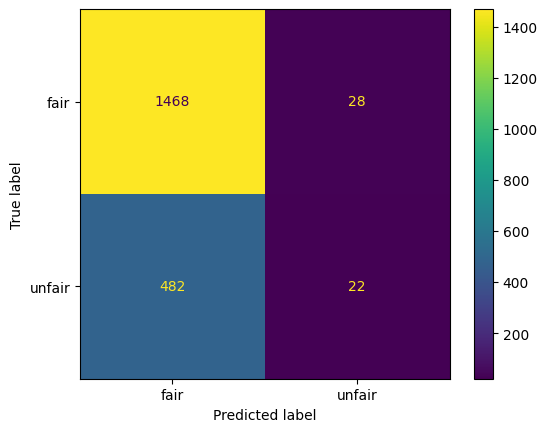

In [139]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

hp_model = tuner.get_best_models()[0]
yhat_test = hp_model.predict(X_test)

yhats = np.where(yhat_test > 0.5, 'fair', 'unfair')
y_cat_test = np.where(y_test == 1, 'fair', 'unfair')

myconfusionmatrix = confusion_matrix(y_cat_test, yhats, labels = ['fair', 'unfair'])

disp = ConfusionMatrixDisplay(confusion_matrix=myconfusionmatrix,
                            display_labels= ['fair', 'unfair'])
disp.plot()
print('Testing set confusion matrix')
print('\n\n\nAccuracy of logistic regression classifier on test set: {:.2f}'.format((myconfusionmatrix[0,0]+myconfusionmatrix[1,1])/myconfusionmatrix.sum()))
print('Precision of logistic regression classifier on test set: {:.2f}'.format(myconfusionmatrix[1,1]/(myconfusionmatrix[0,1]+myconfusionmatrix[1,1])))
print('Recall of logistic regression classifier on test set: {:.2f}'.format(myconfusionmatrix[1,1]/(myconfusionmatrix[1,0]+myconfusionmatrix[1,1])))

In [140]:
# Get the weights and biases from the model
weights, biases = hp_model.layers[0].get_weights()

# Print the coefficients
print("Coefficients:", weights.flatten())
print("Intercept:", biases)

Coefficients: [-0.00064426 -0.04862631 -0.01792942 ... -0.08320431 -0.03219714
 -0.0828834 ]
Intercept: [ 0.00282205 -0.01313108  0.0027631  -0.00759788  0.02399048  0.00289654
 -0.02114171  0.05411946 -0.01451598  0.00444835  0.00669511  0.00055037
 -0.00916637  0.00317818  0.04423746  0.00725082]


In [145]:
# Calculate training error
train_loss, train_accuracy = hp_model.evaluate(X_train, y_train)
print("Training loss")
print(train_loss)
print("Training accuracy")
print(train_accuracy)

# Calculate test error
test_loss, test_accuracy = hp_model.evaluate(X_test, y_test)
print("Testing loss")
print(test_loss)
print("Testing accuracy")
print(test_accuracy)

# Calculate validation error
val_loss, val_accuracy = hp_model.evaluate(X_val, y_val)
print("Validation loss")
print(val_loss)
print("Validation accuracy")
print(val_accuracy)

200/200 [==============================] - 0s 2ms/step - loss: 0.5047 - accuracy: 0.7585
Training loss
0.5046815872192383
Training accuracy
0.7585182785987854
63/63 [==============================] - 0s 2ms/step - loss: 0.5509 - accuracy: 0.7450
Testing loss
0.5508622527122498
Testing accuracy
0.7450000047683716
50/50 [==============================] - 0s 2ms/step - loss: 0.5299 - accuracy: 0.7681
Validation loss
0.5299143195152283
Validation accuracy
0.7681249976158142


## Now, we use K-fold cross validation on the best model of the hyperparameter tuning.

In [142]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import cross_validate
from scikeras.wrappers import KerasClassifier


# Implementing early stopping
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta=0.001, restore_best_weights=True)

# Use RepeatedKFold with n_splits=10, n_repeats=1 to implement 10-fold cross validation
# Used batch_size of 100 so that time wouldn't be too long
estimator = KerasClassifier(model=hp_model, epochs=100, batch_size=100, verbose=0)
kfold=RepeatedKFold(n_splits=10, n_repeats=1)

# Perform cross validation with metrics of accuracy and MSE (cross_validate only accepts neg MSE)
scoring = ['accuracy', 'precision', 'recall']
scores = cross_validate(estimator, X_train, y_train, cv=kfold, n_jobs=1, return_train_score=True, scoring=scoring, verbose=0)

In [143]:
# training the model on the training data
#history = log_model.fit(X_train, y_train, batch_size=1, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose = 0)

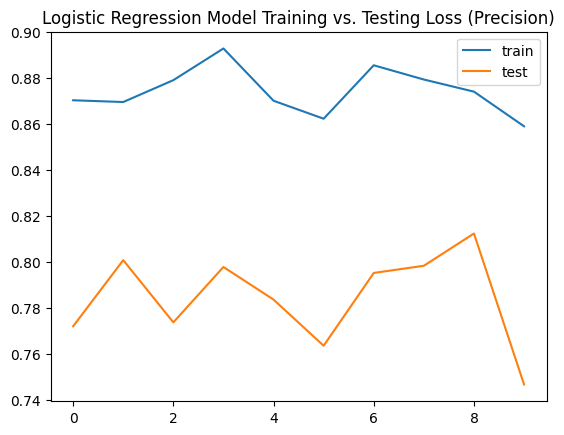

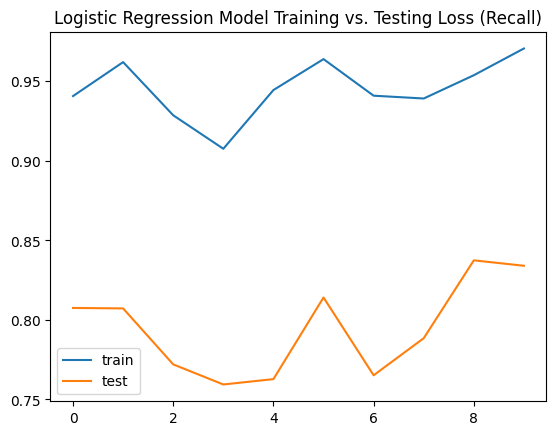

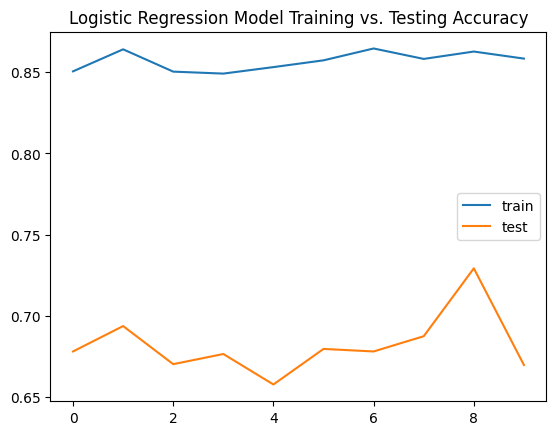

In [144]:
# graphing loss through iterations
plt.plot(scores['train_precision'], label='train')
plt.plot(scores['test_precision'], label='test')
plt.title('Logistic Regression Model Training vs. Testing Loss (Precision)')
plt.legend()
plt.show()

plt.plot(scores['train_recall'], label='train')
plt.plot(scores['test_recall'], label='test')
plt.title('Logistic Regression Model Training vs. Testing Loss (Recall)')
plt.legend()
plt.show()

plt.plot(scores['train_accuracy'], label='train')
plt.plot(scores['test_accuracy'], label='test')
plt.title('Logistic Regression Model Training vs. Testing Accuracy')
plt.legend()
plt.show()